In [0]:
import random
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation


In [0]:
SEED = 2018
random.seed(SEED)
np.random.seed(SEED)

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Android-Malware-Detection/android_dataset.csv')
Y = dataset['class']
X = dataset.drop(['class'], axis=1)
features = X.columns

In [0]:
encoder = LabelEncoder().fit(Y)
Y = encoder.transform(Y)

In [0]:
np.array(X)

In [0]:
est = SVC()
score = -1.0 * cross_val_score(est, X, Y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

CV MSE before feature selection: 0.11


In [0]:
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator 
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=np.bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:
            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring="neg_mean_squared_error"))
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next
	
    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))
        
        return population

    def fit(self, X, y):
 
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []
        
        self.dataset = X, y
        self.n_features = X.shape[1]
        g = 1
        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)
            print('generation:', g)
            g+=1
        return self 
    
    @property
    def support_(self):
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        plt.show()

generation: 1
generation: 2
generation: 3
generation: 4
generation: 5
generation: 6
generation: 7


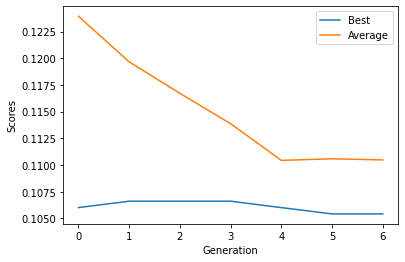

In [0]:
X = X.values
sel = GeneticSelector(estimator=SVC(), 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)
sel.fit(X, Y)
sel.plot_scores()


In [0]:

score = -1.0 * cross_val_score(est, X[:,sel.support_], Y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))

CV MSE after feature selection: 0.11


In [0]:
import pickle
pickle.dump(sel, open('/content/drive/My Drive/Android-Malware-Detection/ga.pkl', 'wb'))

In [0]:
# sel = pickle.load(open('/content/drive/My Drive/Android-Malware-Detection/ga.pkl', 'rb'))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [34]:
AN = Sequential()
AN.add(Dense(256, input_dim = 302, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.3))
AN.add(Dense(32, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(1, activation='sigmoid'))
AN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

AN.fit(X_train.loc[:,sel.support_], y_train, epochs=175, batch_size=32)

scores = AN.evaluate(X_test.loc[:,sel.support_], y_test)
for i in range(len(scores)):
  print("\n%s: %.2f%%" % (AN.metrics_names[i], scores[i]*100))

Epoch 1/175
1343/1343 [==============================] - 0s 186us/step - loss: 0.6880 - accuracy: 0.5838
Epoch 2/175
1343/1343 [==============================] - 0s 90us/step - loss: 0.6608 - accuracy: 0.6992
Epoch 3/175
1343/1343 [==============================] - 0s 103us/step - loss: 0.6433 - accuracy: 0.6902
Epoch 4/175
1343/1343 [==============================] - 0s 87us/step - loss: 0.6302 - accuracy: 0.6955
Epoch 5/175
1343/1343 [==============================] - 0s 97us/step - loss: 0.6203 - accuracy: 0.6932
Epoch 6/175
1343/1343 [==============================] - 0s 98us/step - loss: 0.6099 - accuracy: 0.6925
Epoch 7/175
1343/1343 [==============================] - 0s 91us/step - loss: 0.5988 - accuracy: 0.6955
Epoch 8/175
1343/1343 [==============================] - 0s 90us/step - loss: 0.5840 - accuracy: 0.6962
Epoch 9/175
1343/1343 [==============================] - 0s 90us/step - loss: 0.5757 - accuracy: 0.7089
Epoch 10/175
1343/1343 [==============================] - 0s 9

In [0]:
!pip install androguard

In [36]:
from androguard.core.bytecodes.apk import APK

def predict(apk):
  vector = {}
  a = APK(apk)
  perm = a.get_permissions()
  print(perm)
  for d in features:
    if d in perm:
      vector[d]=1
    else:
      vector[d]=0
  data = [ v for v in vector.values() ]
  data = np.array(data)
  # print(data[sel.support_])
  print(AN.predict([[data[sel.support_]]]))

#predict('/content/drive/My Drive/Android-Malware-Detection/dataset/malign/com.prasesfee.apk')
predict('/content/drive/My Drive/Android-Malware-Detection/dataset/benign/com.whatsapp.apk')

Requested API level 29 is larger than maximum we have, returning API level 28 instead.


['android.permission.READ_EXTERNAL_STORAGE', 'com.sonymobile.home.permission.PROVIDER_INSERT_BADGE', 'android.permission.AUTHENTICATE_ACCOUNTS', 'android.permission.READ_PROFILE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.INSTALL_SHORTCUT', 'android.permission.REQUEST_INSTALL_PACKAGES', 'android.permission.WRITE_CONTACTS', 'android.permission.MANAGE_ACCOUNTS', 'android.permission.ACCESS_NETWORK_STATE', 'com.whatsapp.permission.MAPS_RECEIVE', 'com.sec.android.provider.badge.permission.WRITE', 'com.whatsapp.permission.BROADCAST', 'android.permission.RECORD_AUDIO', 'android.permission.NFC', 'android.permission.USE_FULL_SCREEN_INTENT', 'com.whatsapp.permission.REGISTRATION', 'android.permission.WAKE_LOCK', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.FOREGROUND_SERVICE', 'android.permission.VIBRATE', 'com.google.android.providers.gsf.permission.READ_GSERVICES', 'android.p

In [0]:
pickle.dump(AN, open('/content/drive/My Drive/Android-Malware-Detection/ANN_GA.pkl', 'wb'))

# **SVC**

In [0]:
Y = dataset['class']
X = dataset.drop(['class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [53]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf','sigmoid', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(X_train.loc[:, sel.support_], y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.673, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.673, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.673, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.672, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.672, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.851, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.814, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.848, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.810, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   46.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [54]:
print(grid.best_params_) 
grid_predictions = grid.predict(X_test.loc[:,sel.support_]) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 
pickle.dump(grid, open('/content/drive/My Drive/Android-Malware-Detection/svc_ga.pkl', 'wb'))

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

      benign       0.93      0.93      0.93       247
      malign       0.80      0.80      0.80        89

    accuracy                           0.89       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.89      0.89      0.89       336



In [60]:
def predict(apk):
  vector = {}
  a = APK(apk)
  perm = a.get_permissions()
  print(perm)
  for d in features:
    if d in perm:
      vector[d]=1
    else:
      vector[d]=0
  data = [ v for v in vector.values() ]
  data = np.array(data)
  print(grid.predict([data[sel.support_]]))

#predict('/content/Ransomware/PornDroid/1c53e2c34d1219a2fae8fcf8ec872ac8.apk')
predict('/content/drive/My Drive/Android-Malware-Detection/dataset/benign/com.whatsapp.apk')

Requested API level 29 is larger than maximum we have, returning API level 28 instead.


['android.permission.READ_EXTERNAL_STORAGE', 'com.sonymobile.home.permission.PROVIDER_INSERT_BADGE', 'android.permission.AUTHENTICATE_ACCOUNTS', 'android.permission.READ_PROFILE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.INSTALL_SHORTCUT', 'android.permission.REQUEST_INSTALL_PACKAGES', 'android.permission.WRITE_CONTACTS', 'android.permission.MANAGE_ACCOUNTS', 'android.permission.ACCESS_NETWORK_STATE', 'com.whatsapp.permission.MAPS_RECEIVE', 'com.sec.android.provider.badge.permission.WRITE', 'com.whatsapp.permission.BROADCAST', 'android.permission.RECORD_AUDIO', 'android.permission.NFC', 'android.permission.USE_FULL_SCREEN_INTENT', 'com.whatsapp.permission.REGISTRATION', 'android.permission.WAKE_LOCK', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.FOREGROUND_SERVICE', 'android.permission.VIBRATE', 'com.google.android.providers.gsf.permission.READ_GSERVICES', 'android.p